# TODO

1. Pick a Dataset
2. Download the dataset
3. Import the dataset using Pytorch
4. Explore the dataset
5. Prepare the dataset for training

In [ ]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'
od.download(dataset_url)

100%|██████████| 346M/346M [00:21<00:00, 17.0MB/s]


In [ ]:
import os
from torchvision.datasets import ImageFolder
train_dir = './intel-image-classification/seg_test/seg_test'
test_dir = './intel-image-classification/seg_train/seg_train'

In [ ]:
print("Classes:", ", ".join(os.listdir(train_dir)))

Classes: forest, mountain, sea, buildings, street, glacier


In [140]:
for cls in os.listdir(train_dir):
    print(cls, ':', len(os.listdir(train_dir +'/'+ cls)))

def cls_to_lbl(num):
    if num == 0:
        return "buildings"
    elif num == 1:
        return "forest"
    elif num == 2:
        return "glacier"
    elif num == 3:
        return "mountain"
    elif num == 4:
        return "sea"
    else:
        return "street"

forest : 474
mountain : 525
sea : 510
buildings : 437
street : 501
glacier : 553


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 64
IMG_SIZE = 128

all_dataset = ImageFolder(train_dir,T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)),
                                            T.RandomCrop((IMG_SIZE, IMG_SIZE)),
                                            T.ToTensor()]))
train_size = int(0.85 * len(all_dataset))
val_size =  len(all_dataset) - train_size

# Split the training dataset into training, validation, and test datasets
train_dataset, val_dataset = random_split(all_dataset, [train_size, val_size])

# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


test_dataset = ImageFolder(test_dir,T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)),
                                            T.ToTensor()]))
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)


print(f"Training images: {len(train_dataset)}, Validation images {len(val_dataset)}, Testing images {len(test_dataset)}")

Training images: 2550, Validation images 450, Testing images 14034


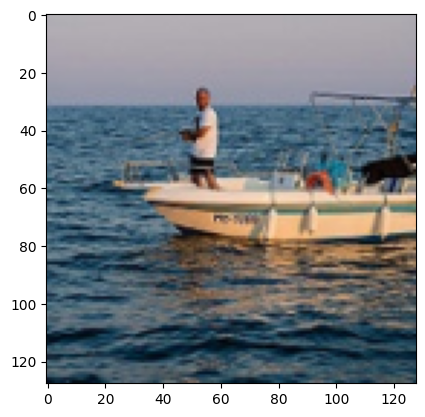

In [ ]:
img, label = train_dataset[500]
plt.imshow(img.permute((1,2,0)))

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for imgs, labels in dl:
        fig, ax = plt.subplots(figsize = (30,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(imgs, nrow=16).permute(1,2,0))
        break

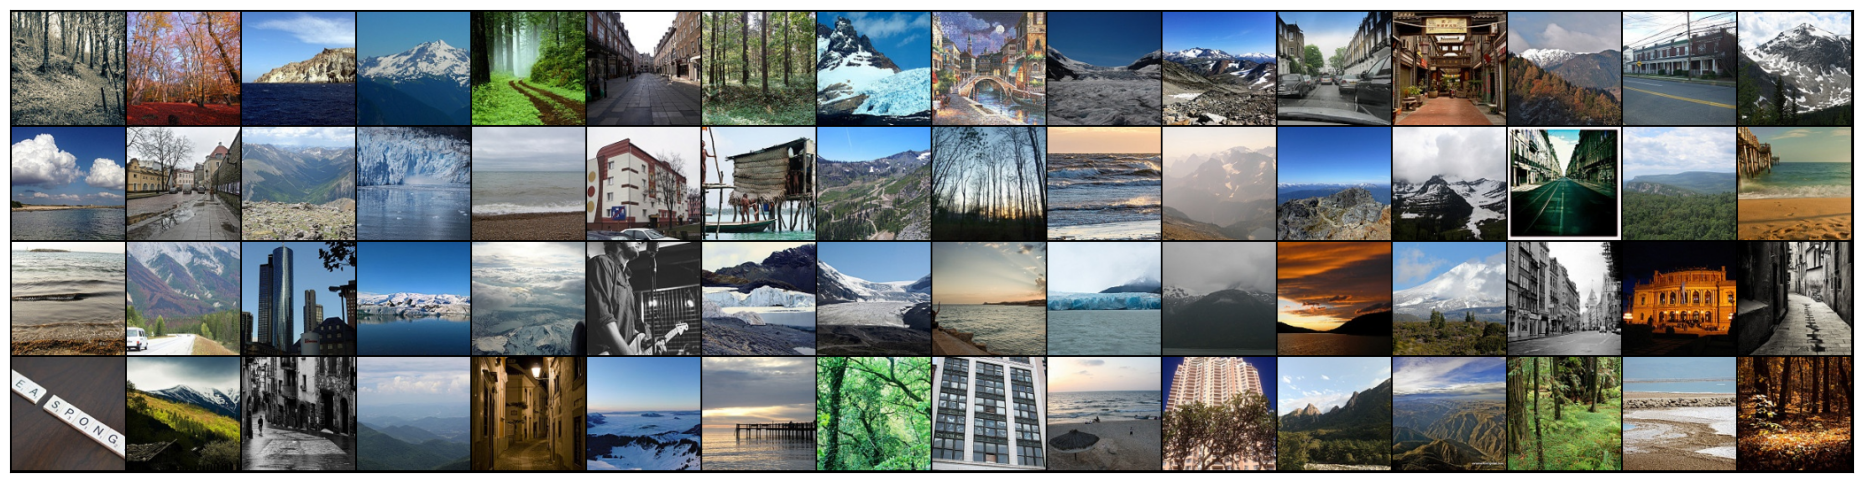

In [ ]:
show_batch(train_loader)

## Utility functions and classes

In [ ]:
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for bt in self.dl:
            yield to_device(bt,self.device)

    def __len__(self):
        return len(self.dl)


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_loader,device)
valid_dl = DeviceDataLoader(val_loader,device)
test_dl = DeviceDataLoader(test_loader,device)

# Model and Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        # calculate loss for a batch of training data
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(self,batch):
        # calculate loss & accuracy for a batch of validation data
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_losses = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_accs = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_losses.item(), 'val_acc': epoch_accs.item()}

    def epoch_end(self,epoch,result):
        print('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch,result['train_loss'],result['val_loss'],result['val_acc']))

def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    # Evalutes the models performance on the validation set
    model.eval()
    outputs = []
    for batch in val_loader:
        outputs.append(model.validation_step(batch))
        val_loss, val_acc = outputs[-1].values()
        if val_acc > 0.85:
            torch.save(model, f"ResNet9 {round(val_acc.item(), 4)}.pth")
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

Resnet 9 architecture

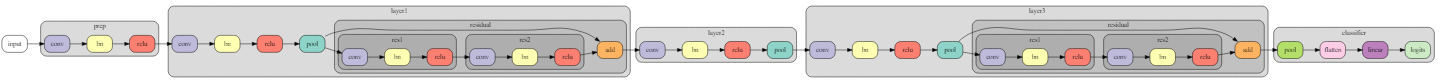

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64)  # Input: 128 x 64 x 128 x 128
        self.conv2 = conv_block(64, 128, pool=True) # Input: 128 x 128 x 64 x 64
        self.res1 = nn.Sequential(conv_block(128, 128), # Input: 128 x 128 x 64 x 64
                                  conv_block(128, 128)) # Input: 128 x 128 x 64 x 64

        self.conv3 = conv_block(128, 256, pool=True) # Input: 128 x 256 x 32 x 32
        self.conv4 = conv_block(256, 512, pool=True)  # Input: 128 x 512 x 16 x 16
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # Input: 128 x 512 x 4 x 4
                                        nn.Flatten(), # Input: 128 x  512
                                        nn.Dropout(0.5),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3,len(all_dataset.classes)),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device # Checking the model device

device(type='cuda', index=0)

Pass one batch of input tensor through the model.

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('',images.shape)
    print(images.device)
    preds = model(images)
    print('Preds shape',preds.shape)
    break

 torch.Size([64, 3, 128, 128])
cuda:0
Preds shape torch.Size([64, 6])


### Training

In [ ]:
history = [evaluate(model,test_dl)]
history

[{'val_loss': 2.3602123260498047, 'val_acc': 0.2049163430929184}]

In [ ]:
history += fit(40, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Validation accuracy reach maximum
Epoch [0], train_loss: 0.6599, val_loss: 0.4750, val_acc: 0.8340
Validation accuracy reach maximum
Epoch [1], train_loss: 0.5854, val_loss: 0.5997, val_acc: 0.8125
Epoch [2], train_loss: 0.5847, val_loss: 0.6082, val_acc: 0.7246
Epoch [3], train_loss: 0.5232, val_loss: 0.4926, val_acc: 0.7793
Validation accuracy reach maximum
Epoch [4], train_loss: 0.4956, val_loss: 0.5059, val_acc: 0.8496
Epoch [5], train_loss: 0.4280, val_loss: 0.9133, val_acc: 0.6562
Epoch [6], train_loss: 0.4649, val_loss: 0.5306, val_acc: 0.7734
Validation accuracy reach maximum
Epoch [7], train_loss: 0.4425, val_loss: 0.6930, val_acc: 0.7793
Validation accuracy reach maximum
Epoch [8], train_loss: 0.4243, val_loss: 0.5535, val_acc: 0.8164
Validation accuracy reach maximum
Epoch [9], train_loss: 0.3827, val_loss: 0.5221, val_acc: 0.8340
Epoch [10], train_loss: 0.3433, val_loss: 0.6245, val_acc: 0.7617
Validation accuracy reach maximum
Epoch [11], train_loss: 0.3755, val_loss: 0.80

In [ ]:
from glob import glob
import os
for i in glob("*.pth"):
    os.remove(i)

In [ ]:
import numpy as np

model = torch.load("/content/ResNet9 1.0.pth")
test_preds = []
org_lbls = []

for img, lbl in test_dl:
    img = img.to(device)
    lbl = lbl.to(device)

    out = model(img)
    preds = torch.argmax(out, 1)
    org_lbls.extend(lbl.detach().cpu())
    test_preds.extend(preds.detach().cpu())

print("Test accuracy:", (np.array(org_lbls) == np.array(test_preds)).sum()/len(test_dataset))

Test accuracy: 0.8449479834687188


forest


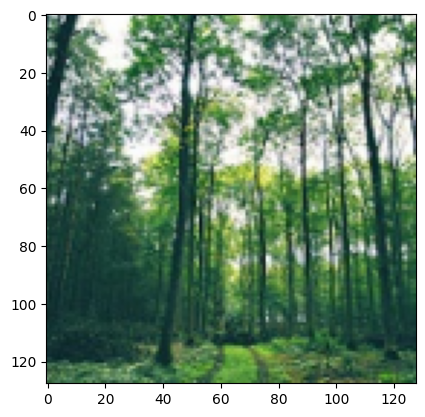

In [143]:
for img, lbl in test_dl:
    plt.imshow(img[0].cpu().permute((1,2,0)))
    print(cls_to_lbl(torch.argmax(model(img), 1)[0].item()))
    plt.show()
    break